In [1]:
import sys
from typing import Tuple


import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from solution_1 import get_grid
from solution_1 import bfs_spiral_add_number_to_grid
from solution_1 import LIST_CYCLE_POSITION_SHIFT
from solution_1 import Grid
from solution_2 import bfs_spiral_add_number_to_grid_inpendent_of_grid


# np.set_printoptions(threshold=sys.maxsize)
# np.set_printoptions(linewidth=sys.maxsize)

In [2]:
def display_solution(matrix, figsize=(10,10)):
    # Get the shape of the matrix
    num_rows, num_cols = matrix.shape

    # Create a meshgrid for X and Y
    np_array_x = np.arange(0, num_cols, 1)
    np_array_y = np.arange(0, num_rows, 1)
    np_array_2d_x, np_array_2d_y = np.meshgrid(np_array_x, np_array_y)

    # Create a 3D plot
    figure_1 = plt.figure(figsize=figsize)
    axes_1 = figure_1.add_subplot(111, projection='3d')

    # Add labels
    axes_1.set_xlabel('X-axis')
    axes_1.set_ylabel('Y-axis')
    axes_1.set_zlabel('Height')

    # Plot the 3D surface
    axes_1.plot_surface(np_array_2d_x, np_array_2d_y, matrix, cmap='viridis')
    
    ####################
    
    figure_2 = plt.figure(figsize=figsize)
    axes_2 = figure_2.add_subplot(111)
    
    image = axes_2.imshow(matrix, cmap='viridis', origin='lower')
    colorbar = figure_2.colorbar(image, ax=axes_2)  # Add colorbar to the subplot

    axes_2.set_title('Height Matrix')
    axes_2.set_xlabel('X-axis')
    axes_2.set_ylabel('Y-axis')
    
    ####################
    
    # Calculate the gradient using np.gradient
    gradient_y, gradient_x = np.gradient(matrix)

    # Create a vector field
    vector_field_x = -gradient_x
    vector_field_y = -gradient_y
    
    figure_3 = plt.figure(figsize=figsize)
    axes_3 = figure_3.add_subplot(111)

    axes_3.quiver(vector_field_x, vector_field_y, scale=20, scale_units='xy', angles='xy')
    axes_3.set_title('Vector Field (Gradient)')
    axes_3.set_xlabel('X-axis')
    axes_3.set_ylabel('Y-axis')

        

# Initial data

In [3]:
list_cycle_position_shift = LIST_CYCLE_POSITION_SHIFT

grid_size_x = 25
grid_size_y = 25

position_start: Tuple[int, int] = (15, 10)


# Solution 1

In [4]:
grid_1 = get_grid(grid_size_x, grid_size_y)

bfs_spiral_add_number_to_grid(
    grid_1, 
    position_start, 
    list_cycle_position_shift
)
    
matrix_1 = np.array(grid_1)
print(matrix_1)

[[625 600 552 506 462 401 402 403 404 405 406 407 408 409 410 411 412 413 414 415 416 417 418 419 420]
 [624 599 551 505 461 400 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361]
 [623 598 550 504 460 399 342 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290]
 [622 597 549 503 459 398 341 272 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 291]
 [621 596 548 502 458 397 340 271 210 157 158 159 160 161 162 163 164 165 166 167 168 169 170 227 292]
 [620 595 547 501 457 396 339 270 209 156 111 112 113 114 115 116 117 118 119 120 121 122 171 228 293]
 [619 594 546 500 456 395 338 269 208 155 110  73  74  75  76  77  78  79  80  81  82 123 172 229 294]
 [618 593 545 499 455 394 337 268 207 154 109  72  43  44  45  46  47  48  49  50  83 124 173 230 295]
 [617 592 544 498 454 393 336 267 206 153 108  71  42  21  22  23  24  25  26  51  84 125 174 231 296]
 [616 591 543 497 453 392 335 266 205 152 107  70  41  20   7   8   9  10

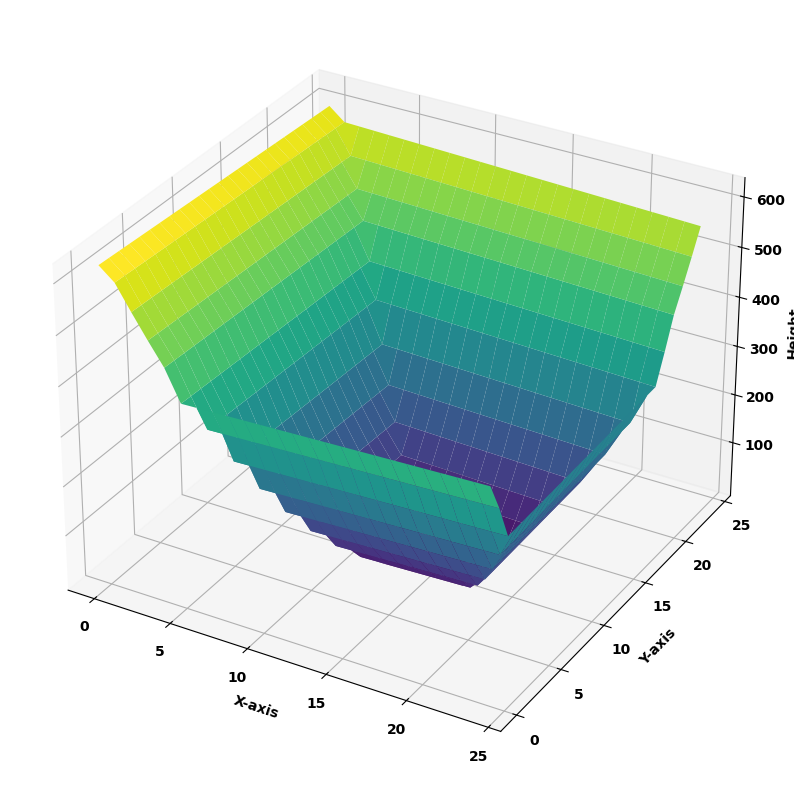

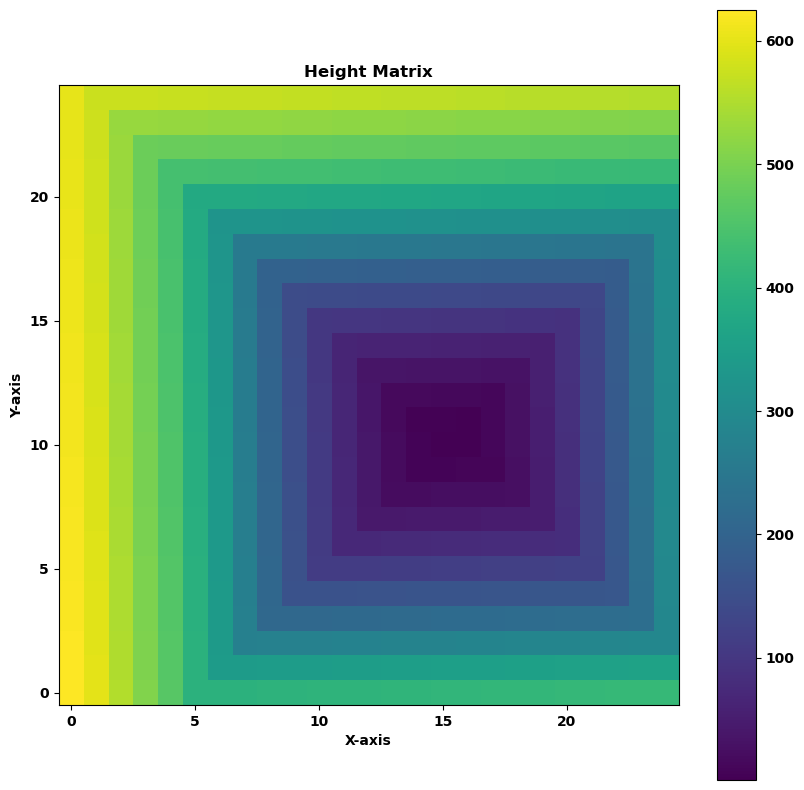

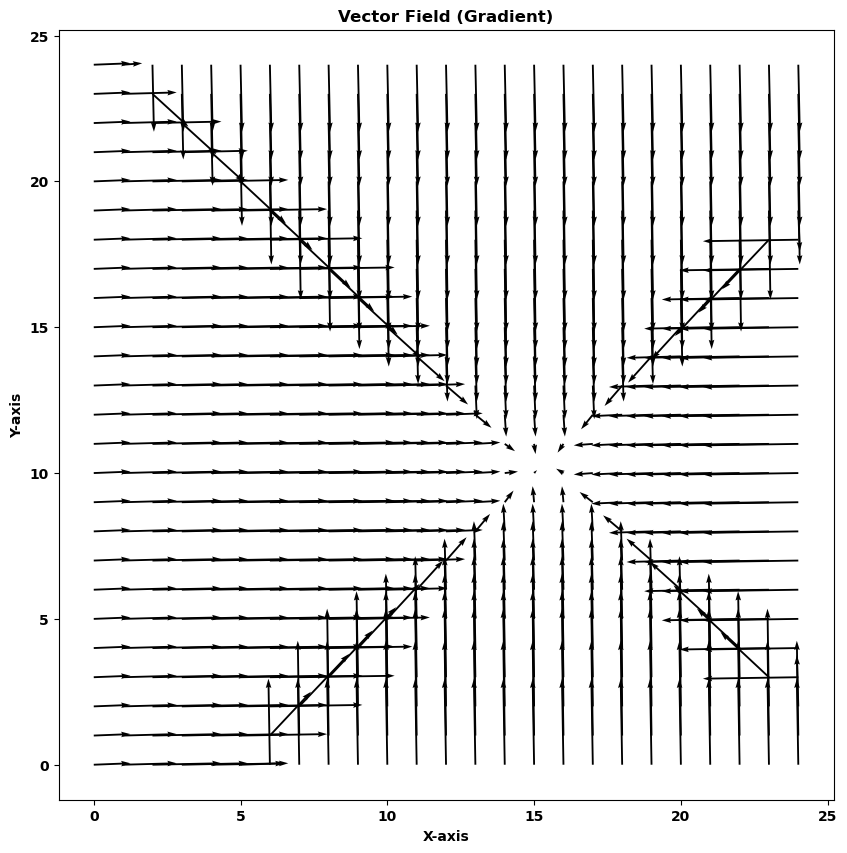

In [5]:
display_solution(matrix_1)

# Solution 2

In [6]:
grid_2 = get_grid(grid_size_x, grid_size_y)

number_of_valid_positions_on_grid = grid_size_x * grid_size_y

bfs_spiral_add_number_to_grid_inpendent_of_grid(
    grid_2, 
    number_of_valid_positions_on_grid, 
    position_start, 
    list_cycle_position_shift
)

matrix_2 = np.array(grid_2)
print(matrix_2)

[[926 809 700 599 506 421 422 423 424 425 426 427 428 429 430 431 432 433 434 435 436 437 438 439 440]
 [925 808 699 598 505 420 343 344 345 346 347 348 349 350 351 352 353 354 355 356 357 358 359 360 361]
 [924 807 698 597 504 419 342 273 274 275 276 277 278 279 280 281 282 283 284 285 286 287 288 289 290]
 [923 806 697 596 503 418 341 272 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 291]
 [922 805 696 595 502 417 340 271 210 157 158 159 160 161 162 163 164 165 166 167 168 169 170 227 292]
 [921 804 695 594 501 416 339 270 209 156 111 112 113 114 115 116 117 118 119 120 121 122 171 228 293]
 [920 803 694 593 500 415 338 269 208 155 110  73  74  75  76  77  78  79  80  81  82 123 172 229 294]
 [919 802 693 592 499 414 337 268 207 154 109  72  43  44  45  46  47  48  49  50  83 124 173 230 295]
 [918 801 692 591 498 413 336 267 206 153 108  71  42  21  22  23  24  25  26  51  84 125 174 231 296]
 [917 800 691 590 497 412 335 266 205 152 107  70  41  20   7   8   9  10

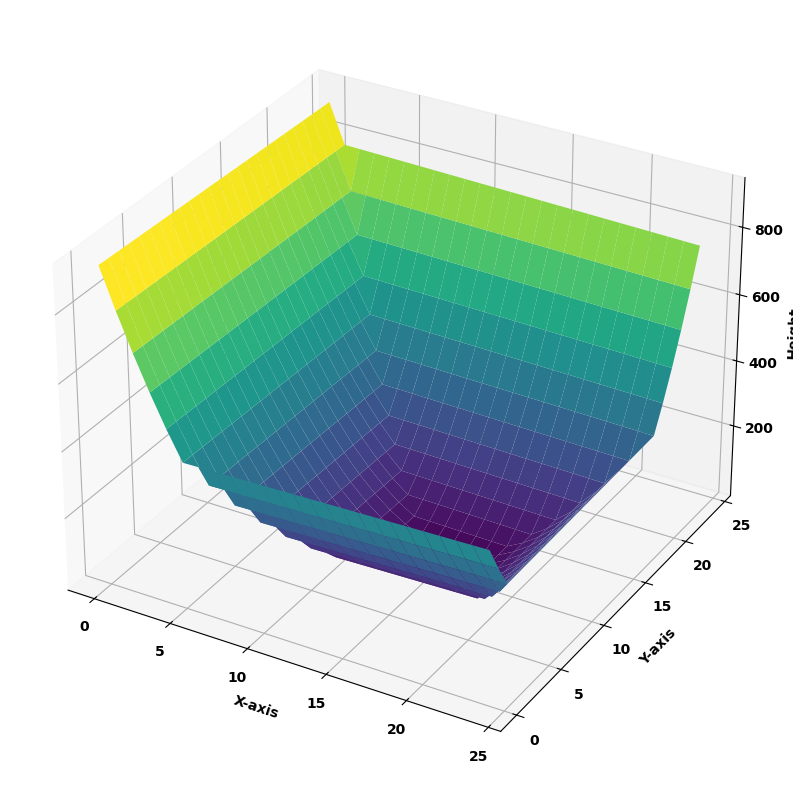

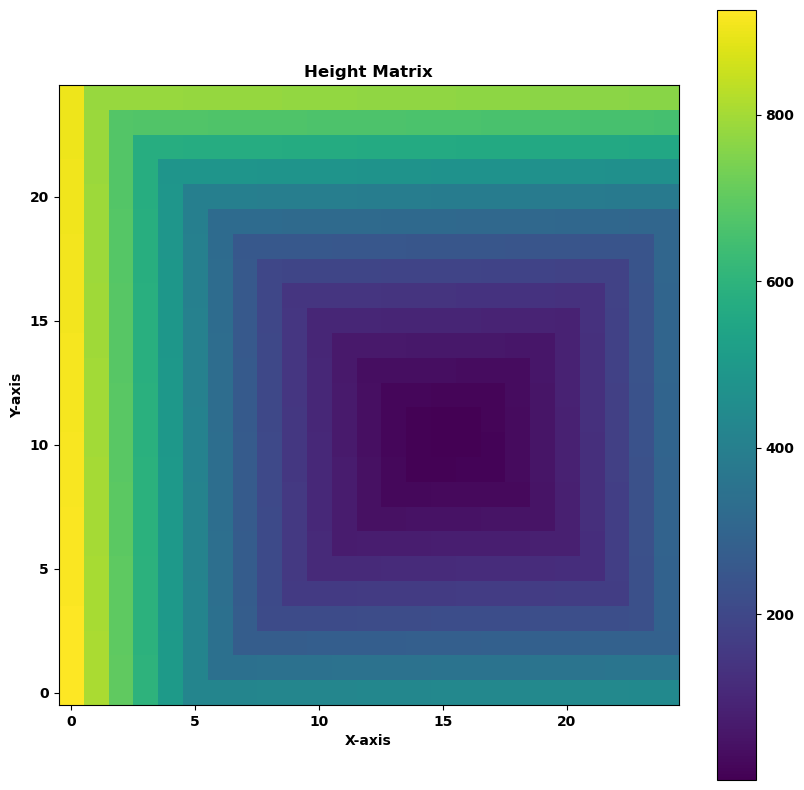

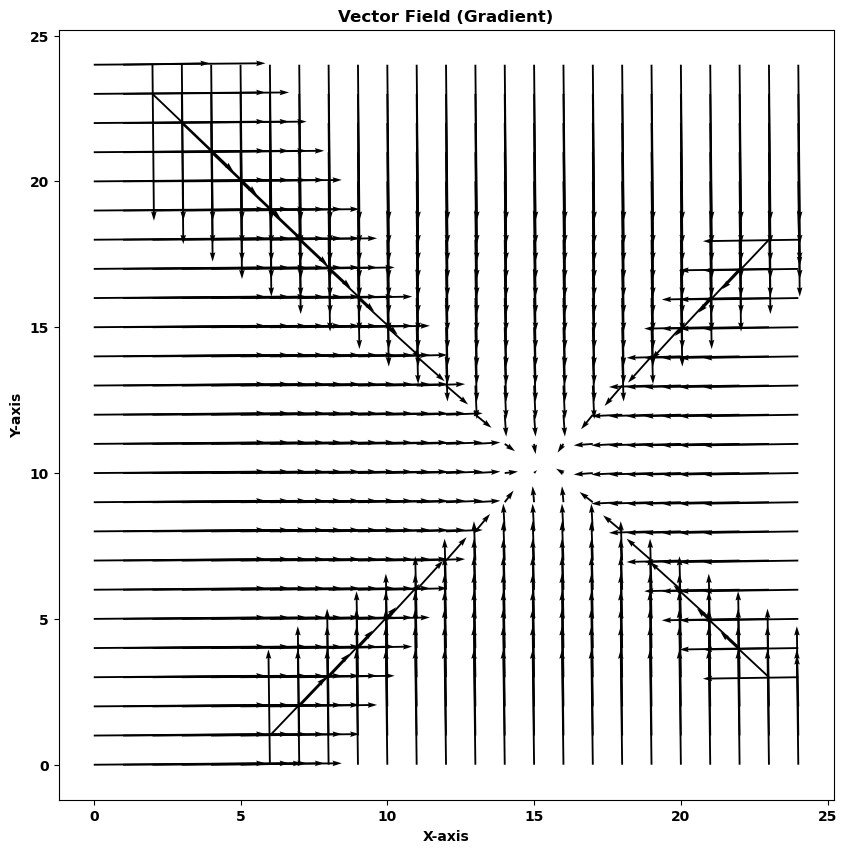

In [7]:
display_solution(matrix_2)

# Testing fun modifications

In [8]:
list_cycle_position_shift_custom = [
    (0, -1),  # Up
    (0, 1),  # Down
    (1, 0),  # Right
    (-1, 0),  # Left
    (1, -1),  # Up Right
    (-1, 1),  # Down Left
    (-1, -1),  # Up Left
    (1, 1),  # Down Right
]


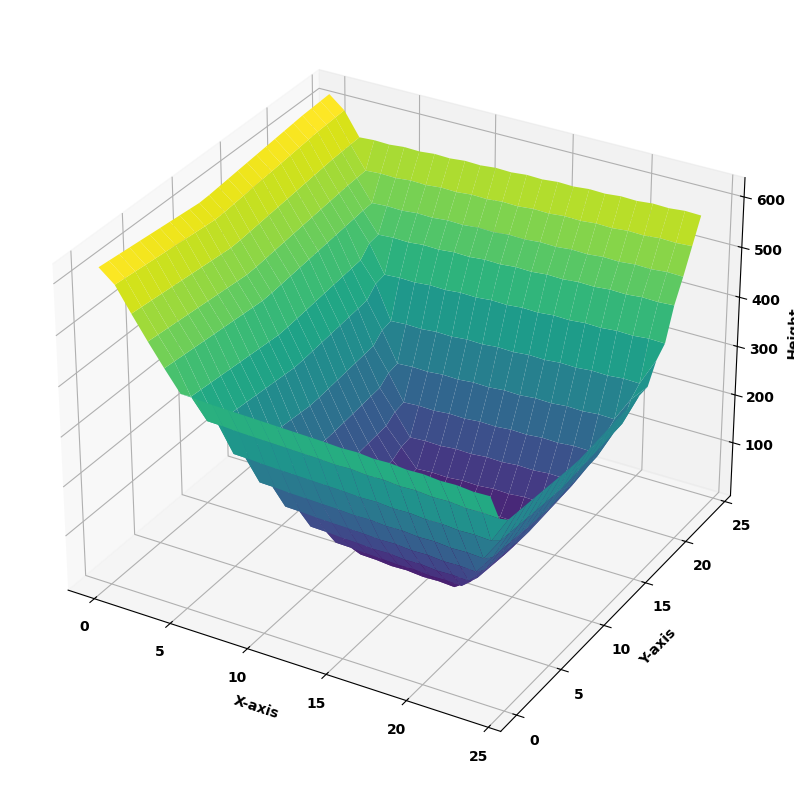

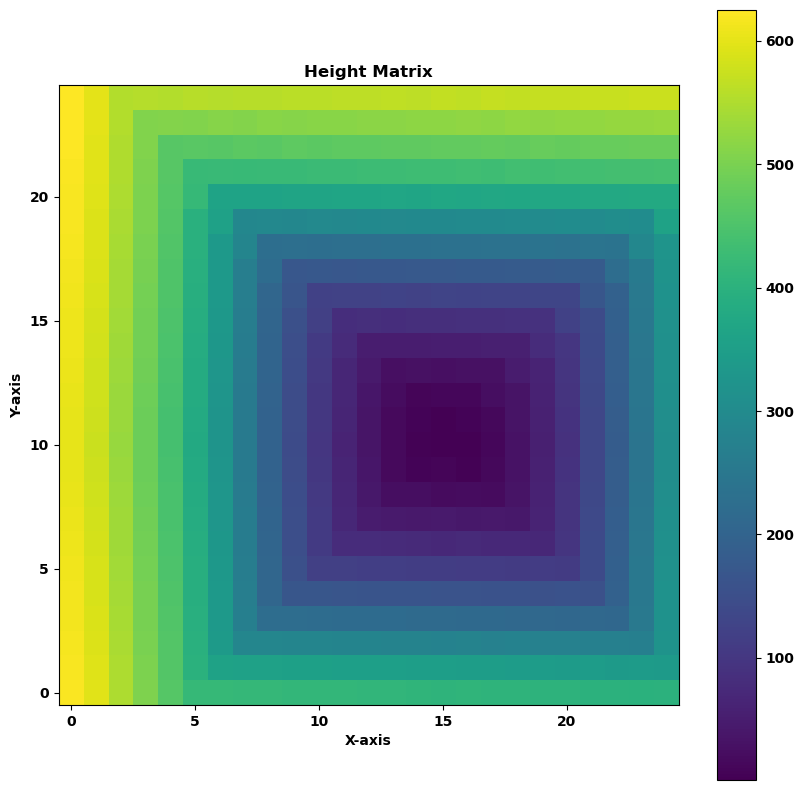

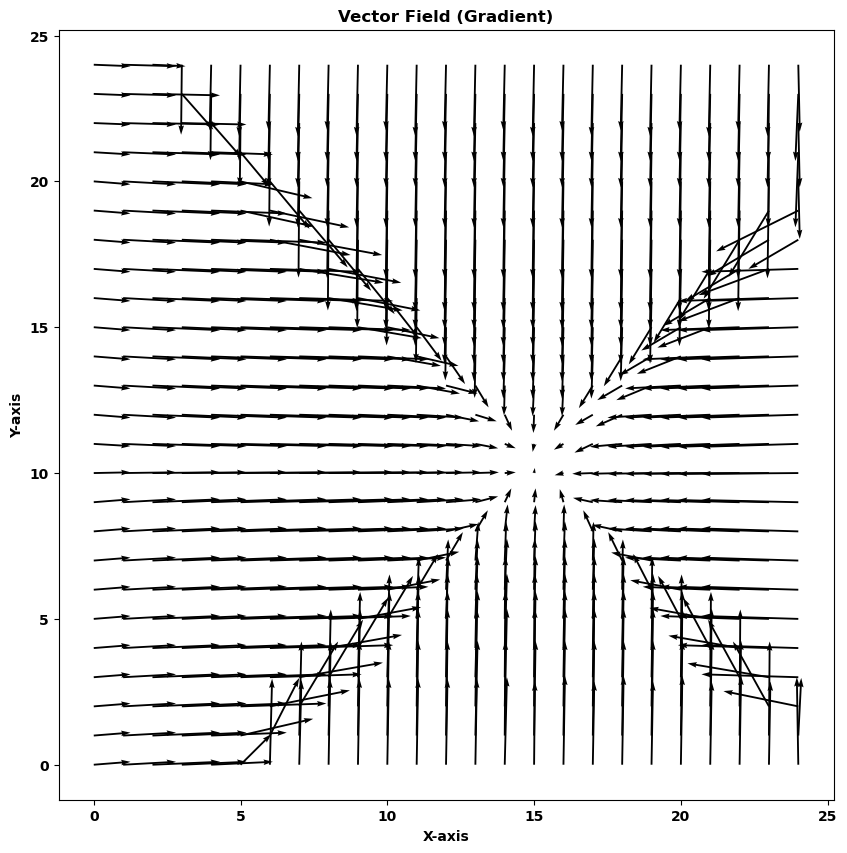

In [9]:
grid_3 = get_grid(grid_size_x, grid_size_y)

bfs_spiral_add_number_to_grid(
    grid_3, 
    position_start, 
    list_cycle_position_shift_custom
)

matrix_3 = np.array(grid_3)
display_solution((matrix_3))

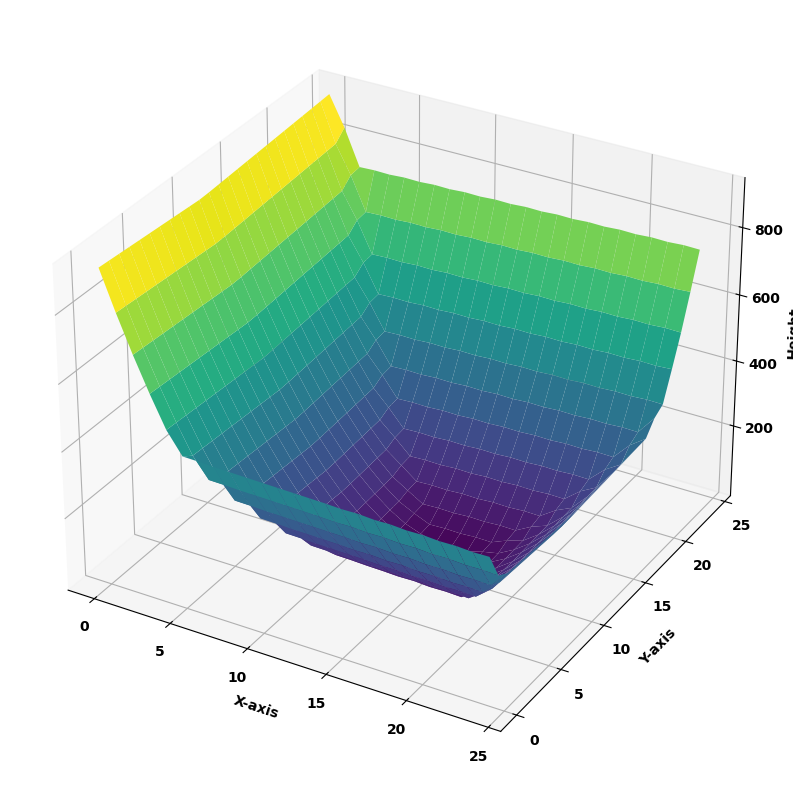

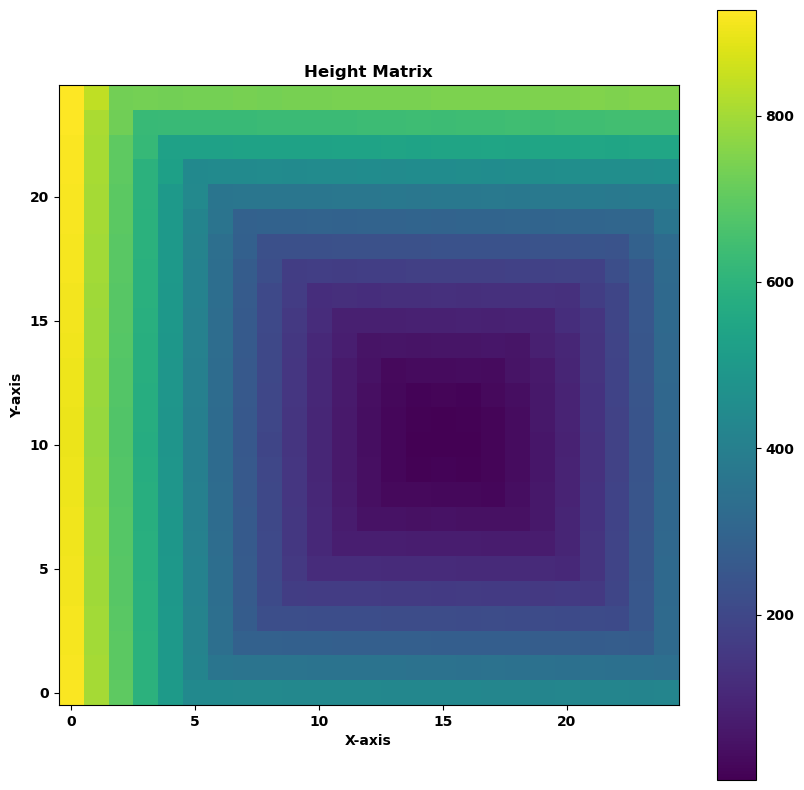

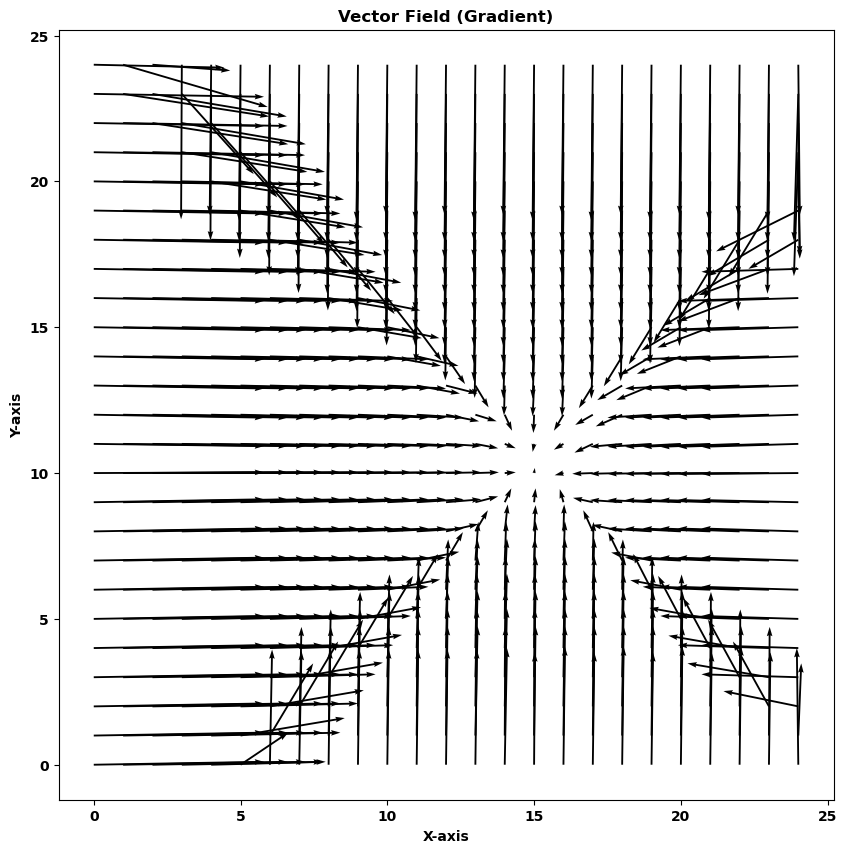

In [10]:
grid_4 = get_grid(grid_size_x, grid_size_y)

number_of_valid_positions_on_grid = grid_size_x * grid_size_y

bfs_spiral_add_number_to_grid_inpendent_of_grid(
    grid_4, 
    number_of_valid_positions_on_grid, 
    position_start, 
    list_cycle_position_shift_custom
)

matrix_4 = np.array(grid_4)
display_solution((matrix_4))
